In [1]:
import os
from math import *

import numpy as np
import pandas as pd
# import sklearn

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import (manifold, datasets, decomposition, ensemble,
             discriminant_analysis, random_projection)
from sklearn.preprocessing import MinMaxScaler

In [2]:
from mylab.myteststationary import *
PLOT_FEATURE = not True
DROP_OUTLIERS =  True
IS_SCALE =  True
IS_REDUCE = True

IS_DEBUG = not True

# dropout

In [3]:
n  = [ 365,349,297,260,251,234,228,185,4,1,
     371,370,359,328,314,148,113,57,16]
m = [i+40 for i in n]
print(m)

[405, 389, 337, 300, 291, 274, 268, 225, 44, 41, 411, 410, 399, 368, 354, 188, 153, 97, 56]


In [4]:
if IS_DEBUG:
    PLOT_FEATURE = not True
    DROP_OUTLIERS = True
if DROP_OUTLIERS:
    # drop outl
    round_num_del = [1,2,3,4,5,6,7,8,9,10,11,12,13,
                     17,18,19,20,21,22,23,
                     405, 389, 337, 300, 291, 274, 268, 225, 44, 41, 411, 410, 399, 368, 354, 188, 153, 97, 56,
#                      24,35,46,112,223,334,386,375,364,
#                      56,153,208,309,327,347,351,360,365,391
                    ]
    round_num_del = [i-1 for i in round_num_del]

    train_df = pd.read_csv('./data/train_feature_df.csv')
    if DROP_OUTLIERS:
        train_df.drop(round_num_del,axis = 0,inplace = True)
#     train_df = train_df.loc[train_df['temperature']>326,:]
    train_df = train_df.loc[train_df['num_cycle']>40,:]
    if PLOT_FEATURE:
        plot_feature1(train_df,"num_cycle",up_pic_dir)
    train_df.to_csv("./temp/train_feature_df_outliers.csv",index = False)

    # show info
    print(train_df.shape)
    train_df.head()

(359, 162)


# scale

In [5]:
if IS_SCALE:
    # std
    train_df = pd.read_csv('./temp/train_feature_df_outliers.csv')
    print(train_df.shape)
    # drop_duplicates
    target = ["temperature","num_cycle"]
    cols = train_df.columns.values
    cols_to_use = [c for c in cols if c not in target]
    for col in cols_to_use:
        ma = train_df[col].max()
        mi = train_df[col].min()
        train_df[col] = (train_df[col]-mi)/(ma-mi)

    train_df.to_csv("temp/train_feature_df_outliers_useful_scale.csv",index = False)
    print(train_df.shape)
    train_df.head()

(359, 162)
(359, 162)


# excise temperature influence

In [6]:
df = pd.DataFrame()
for theta in range(-30,-10):
    col = "reduce_"+str(abs(theta))
    x = train_df.down_collectorEmitterVoltage_llr
    y = (train_df.temperature-326)/5.0
    df[col] = x*cos(radians(theta))+ y*sin(radians(theta))
df["num_cycle"] = train_df["num_cycle"]    
df["down_collectorEmitterVoltage_llr"] = train_df["down_collectorEmitterVoltage_llr"] 
corr_df = df.corr().abs()
corr_df.sort_values(by = ["num_cycle"],ascending = False,inplace = True)
corr_df = corr_df.loc[:,corr_df.index.values]
# plot
print(corr_df.index.values[1],corr_df.num_cycle.values[1])
df.loc[:,["num_cycle","down_collectorEmitterVoltage_llr",corr_df.index.values[1]]].to_csv("temp/train_most_effective_cols.csv",index = False)

reduce_25 0.882985961616


# test stationarity

### Original Series

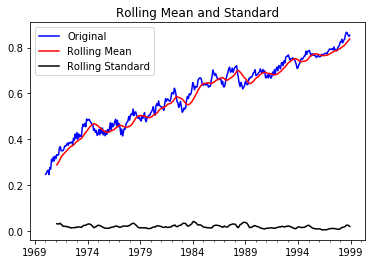

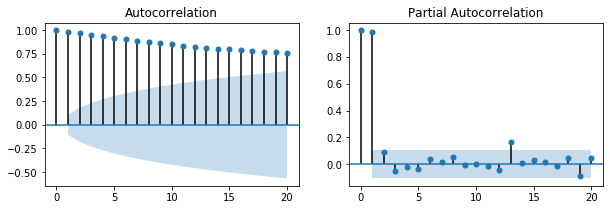

Test Statistic                  -1.416870
p-value                          0.574162
#Lags Used                      13.000000
Number of Observations Used    334.000000
Critical Value (1%)             -3.450081
Critical Value (5%)             -2.870233
Critical Value (10%)            -2.571401
dtype: float64

In [7]:
# import test_stationarity
train_df = pd.read_csv("temp/train_most_effective_cols.csv")
ts = train_df.down_collectorEmitterVoltage_llr
# ts = train_df.reduce_23 
ts = ts.rolling(window=12).mean().dropna()
ts.index = pd.DatetimeIndex(start=0,periods=len(ts.values),freq='MS')
# ts_log = np.log(ts)
draw_trend(ts, 14)
draw_acf_pacf(ts,20)
test_stationarity(ts)

Text(0.5, 1.0, 'RSS: 0.0666')

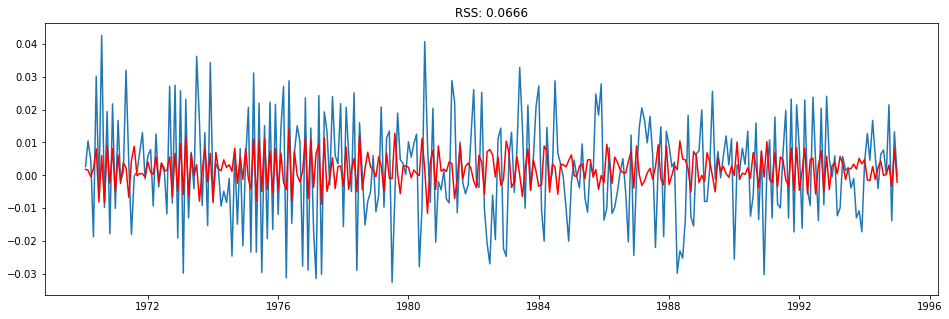

In [8]:
from statsmodels.tsa.arima_model import ARIMA
train_ts = ts[:301]
test_ts = ts[302:]
model = ARIMA(train_ts, order=(1,1,2))
model_ARIMA = model.fit(disp = -1)
train_ts_diff = train_ts.diff(1).dropna()
plt.figure(figsize=(16,5))
plt.plot(train_ts_diff)
plt.plot(model_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((model_ARIMA.fittedvalues-train_ts_diff)**2))

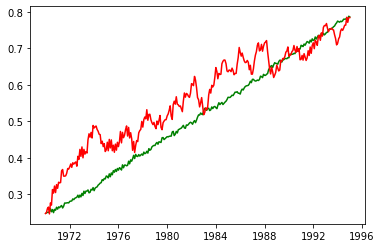

In [9]:
pre_ts = model_ARIMA.fittedvalues.cumsum()+train_ts.values[0]
plt.plot(pre_ts,color = "green")
plt.plot(train_ts,color = "red")

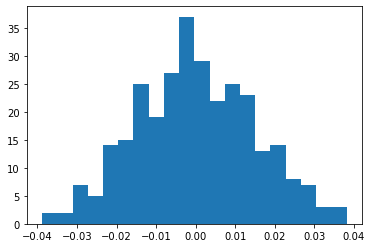

In [10]:
# plt.plot((ARIMA.fittedvalues-train_ts_diff))
plt.hist((model_ARIMA.fittedvalues-train_ts_diff),bins=20)
plt.show()

# predict

In [ ]:
from sklearn.metrics import mean_squared_error
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

X = ts
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
predictions = list()
for t in range(len(test)):
    train = X[0:size+t]
    model = ARIMA(train, order=(1,1,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0][0]
    predictions.append(yhat)
    obs = test[t]
#     print('predicted=%f, expected=%f' % (yhat, obs))
    
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test.values)
plt.plot(predictions, color='red')
plt.show()

Test MSE: 0.000


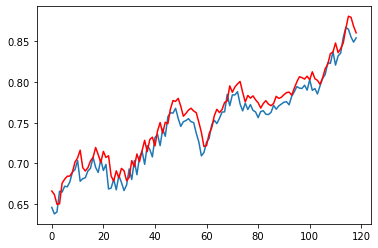

In [37]:
from sklearn.metrics import mean_squared_error
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
PRE_STEP = 7
X = ts
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
predictions = list()
for t in range(len(test)):
    train = X[0:size+t]
    model = ARIMA(train, order=(1,1,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast(steps = PRE_STEP)
    yhat = output[0][PRE_STEP-1]
    predictions.append(yhat)
    obs = test[t]
#     print('predicted=%f, expected=%f' % (yhat, obs))
    
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test.values)
plt.plot(predictions, color='red')
plt.show()

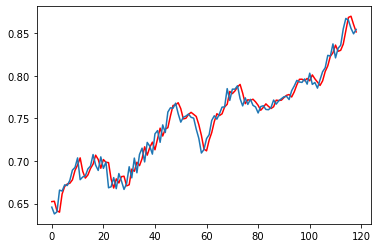

In [32]:
plt.plot(predictions, color='red')
plt.plot(test.values)

In [46]:
import tensorflow as tf
import tensorflow_probability as tfp

class DeepAR(tf.keras.models.Model):
    """
    DeepAR 模型
    """
    def __init__(self, lstm_units):
        super().__init__()
        # 注意，文章中使用了多层的 LSTM 网络，为了简单起见，本 demo 只使用一层
        self.lstm = tf.keras.layers.LSTM(lstm_units, return_sequences=True, return_state=True)
        self.dense_mu = tf.keras.layers.Dense(1)
        self.dense_sigma = tf.keras.layers.Dense(1, activation='softplus')

    def call(self, inputs, initial_state=None):
        outputs, state_h, state_c = self.lstm(inputs, initial_state=initial_state)

        mu = self.dense_mu(outputs)
        sigma = self.dense_sigma(outputs)
        state = [state_h, state_c]

        return [mu, sigma, state]
def log_gaussian_loss(mu, sigma, y_true):
    """
    Gaussian 损失函数
    """
    return -tf.reduce_sum(tfp.distributions.Normal(loc=mu, scale=sigma).log_prob(y_true))

ModuleNotFoundError: No module named 'tensorflow_probability'

In [ ]:
LSTM_UNITS = 16
EPOCHS = 5
# 实例化模型
model = DeepAR(LSTM_UNITS)
# 指定优化器
optimizer = tf.keras.optimizers.Adam()
# 使用 RMSE 衡量误差
rmse = tf.keras.metrics.RootMeanSquaredError()
# 定义训练步def train_step(x, y):
    with tf.GradientTape() as tape:
        mu, sigma, _ = model(x)
        loss = log_gaussian_loss(mu, sigma, y)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    rmse(y, mu)
# 数据处理（略）# train_data = do_something()
# 训练for epoch in range(EPOCHS):
    for x, y in train_data:
        train_step(x, y)
    print('Epoch %d, RMSE %.4f' % (epoch + 1, rmse.result()))
    rmse.reset_states()


### differentiated series

In [ ]:
diff_1 = ts.diff(1)
diff_1.dropna(inplace=True)
draw_trend(diff_1, 17)
draw_acf_pacf(diff_1,20)
test_stationarity(diff_1)

### rolling and differentiated series

In [ ]:
ts_rol = ts.rolling(window=12).mean()
ts_rol_diff1 = ts_rol.diff(1)
ts_rol_diff1.dropna(inplace=True)
draw_trend(ts_rol_diff1, 11)
draw_acf_pacf(ts_rol_diff1,20)
test_stationarity(ts_rol_diff1)

# seasonal analysis

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts, model="additive")

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
draw_ts(ts)
draw_ts(trend)
draw_ts(seasonal)
draw_ts(residual)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
ts_rol.dropna(inplace=True)
decomposition = seasonal_decompose(ts_rol, model="additive")

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
draw_ts(ts_rol)
draw_ts(trend)
draw_ts(seasonal)
draw_ts(residual)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
diff_1 = diff_1.dropna()
decomposition = seasonal_decompose(diff_1, model="additive")

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
draw_ts(trend)
draw_ts(seasonal)
draw_ts(residual)

In [ ]:
t = train_df.temperature
t.index = pd.DatetimeIndex(start=0,periods=len(ts.values),freq='MS')
decomposition = seasonal_decompose(t, model="additive")

t_trend = decomposition.trend
t_seasonal = decomposition.seasonal
t_residual = decomposition.resid
draw_ts(t_trend)
draw_ts(t_seasonal)
draw_ts(t_residual)

In [ ]:
a = ts-(t-290)*0.05
draw_ts(a)
decomposition = seasonal_decompose(a, model="additive")
t_trend = decomposition.trend
t_seasonal = decomposition.seasonal
t_residual = decomposition.resid
draw_ts(t_trend)
draw_ts(t_seasonal)
draw_ts(t_residual)

In [ ]:

rol_mean = ts_log.rolling(window=12).mean()
rol_mean.dropna(inplace=True)
ts_diff_1 = rol_mean.diff(1)
ts_diff_1.dropna(inplace=True)
teststationarity(ts_diff_1


In [ ]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(ts_diff1, order=(1, 1)) 
result_arma = model.fit( disp=-1, method='css')